In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [133]:
reviewsdf = pd.read_pickle('../data/reviewsred.pk')
cooktimes = pd.read_pickle('../data/cooktimesclean.pk')
reviewsdf.head()

,ReviewId,RecipeId,AuthorId,Rating
1,7,4384,1634,4
2,9,4523,2046,2
3,13,7435,1773,5
5,17,5221,2046,4
6,19,13307,2046,5


In [67]:
def get_dictionaries(ratingsdf:pd.core.frame.DataFrame,usercol:str,itemcol:str,ratingcol:str):
    users = list(set(ratingsdf[usercol].values))
    items = list(set(ratingsdf[itemcol].values))
    ratings_by_user = {user_id:{} for user_id in users}
    users_by_item = {item_id:[] for item_id in items}
    for review_index in ratingsdf.index:
        user_id = ratingsdf[usercol][review_index]
        item_id = ratingsdf[itemcol][review_index]
        rating = ratingsdf[ratingcol][review_index]
        ratings_by_user[user_id][item_id] = rating
        users_by_item[item_id].append(user_id)
    return ratings_by_user,users_by_item

user_ratings,recipe_reviewers = get_dictionaries(reviewsdf,'AuthorId','RecipeId','Rating')

In [147]:
def convert_ratings(user_rating_dic:dict)->dict:
    user_mean = np.mean(list(user_rating_dic.values()))
    user_max = max(list(user_rating_dic.values()))
    new_ratings = {}
    for item in user_rating_dic:
        if user_rating_dic[item]==user_max:
            new_ratings[item]=1
        elif user_rating_dic[item] >= user_mean:
            new_ratings[item]=0
        else:
            new_ratings[item]=-1
    return new_ratings

user_ratings_var = {user:convert_ratings(user_ratings[user]) for user in user_ratings}

reviewsdf['Rating0']=[user_ratings_var[reviewsdf['AuthorId'][i]][reviewsdf['RecipeId'][i]]
                      for i in reviewsdf.index]

In [114]:
reviewsdf['Rating0'].value_counts()

Rating0
 1    798973
-1    279988
 0     23921
Name: count, dtype: int64

In [115]:
users.sort(key =lambda x:len(user_ratings[x]))

(array([ 37281.,   8507.,  13298.,  43706., 204775., 795315.]),
 array([0.        , 0.83333333, 1.66666667, 2.5       , 3.33333333,
        4.16666667, 5.        ]),
 <BarContainer object of 6 artists>)

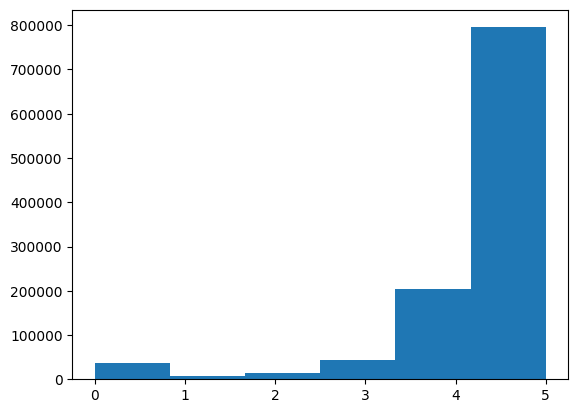

In [58]:
plt.hist(x=reviewsdf.Rating,bins=6)

(array([279988.,  23921., 798973.]),
 array([-1.        , -0.33333333,  0.33333333,  1.        ]),
 <BarContainer object of 3 artists>)

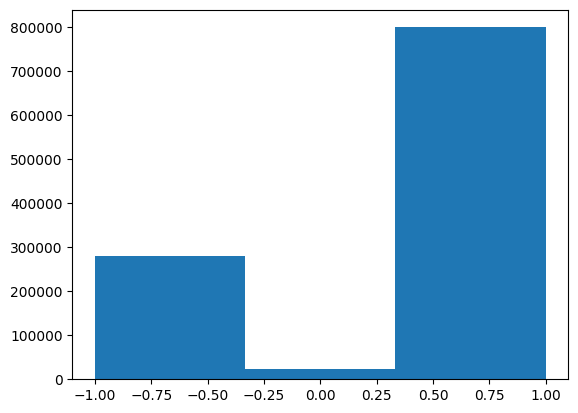

In [59]:
plt.hist(x=reviewsdf.Rating0,bins=3)

In [136]:
class RatingsData:
    def __init__(self,ratingsdataframe:pd.core.frame.DataFrame,usercol:str,itemcol:str,ratingcol:str):
        self.dataframe = ratingsdataframe
        self.usercol = usercol
        self.itemcol = itemcol
        self.userlist = list(set(ratingsdataframe[usercol].values))
        self.itemlist = list(set(ratingsdataframe[itemcol].values))
        self.ratingcol = ratingcol
        self.user_ratings = {}
        self.users_by_item = {}
        self.features = []

    def add_feature(self,feature_df:pd.core.frame.DataFrame,feature_name:'str')->None:
        df0 = self.dataframe
        itemcol = self.itemcol
        newcol = []
        for i in df0.index:
            item = df0[itemcol][i]
            if item in feature_df.index:
                newcol.append(feature_df[feature_name][item])
            else:
                newcol.append(None)
        self.dataframe[feature_name] = newcol
        self.features.append(feature_name)

    def get_dicts(self,insist = False)->None:
        if len(self.user_ratings) == 0 or insist == True:
            user_ratings, users_by_item = get_dictionaries(self.dataframe,
                                                           self.usercol,
                                                           self.itemcol,
                                                           self.ratingcol)
            self.user_ratings = user_ratings
            self.users_by_item = users_by_item
    
    def get_user_lists(self,min_revs=1,min_std=-1,max_mean = 5):
        get_dicts()
        user_ratings = self.user_ratings
        user_list = []
        for user in user_ratings:
            vals = list(user_ratings[user].values())
            if len(vals)>=min_revs and np.mean(vals)<= max_mean and np.std(vals)>min_std:
                user_list.append(user)
        return user_list


    def restr_dataframe(self,user_list:list,item_list:list)->pd.core.frame.DataFrame:
        df = self.dataframe
        usercol = self.usercol
        itemcol = self.itemcol
        df0 = df[df[usercol].isin(user_list)]
        df1 = df0[df0[itemcol].isin(item_list)]
        return df1
    
    def user_related_dataframe(self,user,min_ratingcount_item = 0):
        df = self.dataframe
        usercol = self.usercol
        df0 = df.loc[df[usercol]==user]
        relevant_items = list(df0[self.itemcol].values)
        df1 = df[df[self.itemcol].isin(relevant_items)]
        relevant_users = list(set(df1[usercol].values))
        df1 = self.restr_dataframe(relevant_users,relevant_items)
        if min_ratingcount_item == 0:
            return df1
        else:
            df1 = df1.groupby(self.itemcol).filter(lambda x: len(x) > min_ratingcount_item)
        return df1
        
    

    

In [148]:
rd = RatingsData(reviewsdf,usercol='AuthorId',itemcol='RecipeId',ratingcol='Rating')

In [149]:
rd.add_feature(cooktimes,'Prep')
rd.add_feature(cooktimes,'Cook')
rd.add_feature(cooktimes,'Total')

## Cooking time

Let's add cooking time as a feature.

In [150]:
df = rd.dataframe

In [151]:
df.head()

,ReviewId,RecipeId,AuthorId,Rating,Cook,Prep,Total,Rating0
1,7,4384,1634,4,120.0,5.0,125.0,0
2,9,4523,2046,2,30.0,30.0,60.0,-1
3,13,7435,1773,5,200.0,75.0,275.0,1
5,17,5221,2046,4,0.0,0.0,0.0,0
6,19,13307,2046,5,6.0,30.0,36.0,1


In [142]:
len(users_top)

1137

In [143]:
users_top.sort(key = lambda x:np.mean(list(user_ratings_var[x].values())))

In [145]:
df.columns

Index(['ReviewId', 'RecipeId', 'AuthorId', 'Rating', 'Cook', 'Prep', 'Total'], dtype='object')

In [163]:
df.loc[df.AuthorId == users_top[70]]['Rating0']

974097     1
974099     0
974100    -1
974101     0
974102     1
          ..
1260697    1
1263907    0
1265073    0
1265696    0
1317674   -1
Name: Rating0, Length: 287, dtype: int64

In [183]:
df0.loc[df0.Rating0==0]['LogTotal']

974099     2.302585
974101     3.401197
974107     4.174387
974109     6.318968
974114     4.094345
             ...   
1244399    3.218876
1245971    4.007333
1263907    2.639057
1265073    4.174387
1265696    4.442651
Name: LogTotal, Length: 136, dtype: float64

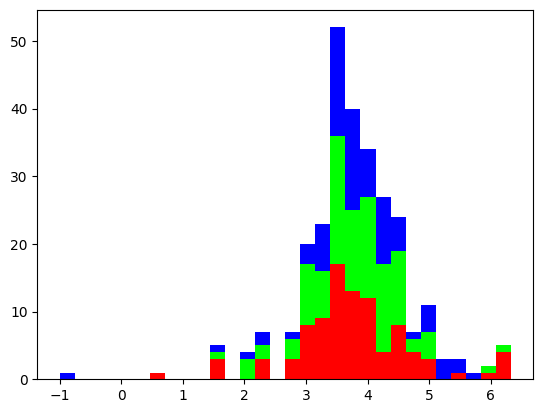

In [191]:
plt.hist(x = [df0.loc[df0.Rating0==-1]['LogTotal'].values,
              df0.loc[df0.Rating0==0]['LogTotal'].values,
              df0.loc[df0.Rating0==1]['LogTotal'].values],
         bins=30,
         histtype = 'barstacked',
         color=[[1,0,0],[0,1,0],[0,0,1]])
plt.show()

In [169]:
df['LogTotal']=df['Total'].apply(log_ext)

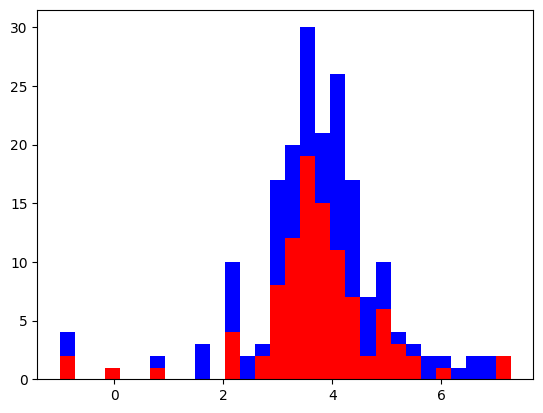

In [195]:
plt.hist(x = [df.loc[df.AuthorId==users_top[90]].loc[df.Rating0==-1]['LogTotal'].values,
              df.loc[df.AuthorId==users_top[90]].loc[df.Rating0== 0]['LogTotal'].values,
              df.loc[df.AuthorId==users_top[90]].loc[df.Rating0== 1]['LogTotal'].values],
         bins=30,
         histtype = 'barstacked',
         color=[[1,0,0],[0,1,0],[0,0,1]])
plt.show()

In [1]:
df0 =df.loc[df.AuthorId == users_top[75]]

NameError: name 'df' is not defined

In [178]:
df0['Rating0'].apply(int_to_color).values

array([list([0, 1, 0]), list([1, 0, 0]), list([0, 0, 1]), list([1, 0, 0]),
       list([0, 1, 0]), list([0, 0, 1]), list([0, 0, 1]), list([1, 0, 0]),
       list([1, 0, 0]), list([1, 0, 0]), list([1, 0, 0]), list([0, 0, 1]),
       list([0, 1, 0]), list([0, 1, 0]), list([0, 0, 1]), list([1, 0, 0]),
       list([1, 0, 0]), list([0, 1, 0]), list([0, 1, 0]), list([0, 0, 1]),
       list([0, 0, 1]), list([1, 0, 0]), list([1, 0, 0]), list([0, 0, 1]),
       list([1, 0, 0]), list([1, 0, 0]), list([0, 0, 1]), list([1, 0, 0]),
       list([0, 1, 0]), list([1, 0, 0]), list([1, 0, 0]), list([0, 0, 1]),
       list([1, 0, 0]), list([1, 0, 0]), list([1, 0, 0]), list([1, 0, 0]),
       list([1, 0, 0]), list([1, 0, 0]), list([0, 0, 1]), list([0, 0, 1]),
       list([1, 0, 0]), list([1, 0, 0]), list([1, 0, 0]), list([0, 1, 0]),
       list([0, 1, 0]), list([1, 0, 0]), list([1, 0, 0]), list([0, 0, 1]),
       list([1, 0, 0]), list([0, 0, 1]), list([0, 0, 1]), list([0, 1, 0]),
       list([0, 1, 0]), l